In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf  # Import TensorFlow library
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import ImageDataGenerator for image preprocessing
from keras.applications.vgg16 import VGG16  # Import VGG16 model
from keras.optimizers import Adam  # Import Adam optimizer
from keras.models import Model, load_model  # Import Model for defining neural network models
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, GlobalAveragePooling2D  # Import various layers from Keras
import warnings  # Import warnings module
import os  # Import os module
from sklearn.utils import compute_class_weight
warnings.filterwarnings('ignore')  # Ignore warnings
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score  # Import various metrics for model evaluation
import seaborn as sns  # Import seaborn for confusion matrix visualization


2025-07-29 06:48:21.827816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753771702.033916      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753771702.087816      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Define constants
BATCH_SIZE = 16  # Adjust based on your GPU memory (e.g., 32 if it fits)
IMG_SIZE = (224, 224)  # VGG16 input size
EPOCHS = 20  # Adjust as needed
SAVE_NAME = 'vgg16_real_fake_model'  # Name for saving model

# Dataset paths (Kaggle input is read-only)
BASE_PATH = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
VALID_DIR = os.path.join(BASE_PATH, 'valid')
TEST_DIR = os.path.join(BASE_PATH, 'test')

# Get class names (should be ['fake', 'real'])
class_subset = sorted(os.listdir(TRAIN_DIR))
print("Classes:", class_subset)


Classes: ['fake', 'real']


In [4]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=90,  # Random rotation
    rescale=1/255.,  # Normalize pixel values
    brightness_range=[0.5, 1.0],  # Random brightness
    width_shift_range=0.5,  # Horizontal shift
    height_shift_range=0.5,  # Vertical shift
    horizontal_flip=True,  # Horizontal flip
    vertical_flip=True  # Vertical flip
)

# Validation and test generators (no augmentation, just rescaling)
valid_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    class_mode='binary',  # Binary classification (0: fake, 1: real or vice versa)
    classes=class_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    class_mode='binary',
    classes=class_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    class_mode='binary',  # Use 'binary' for labels during evaluation
    classes=class_subset,
    batch_size=1,  # For prediction
    shuffle=False,
    seed=42
)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


Class Indices: {'fake': 0, 'real': 1}
Class 0: fake
Class 1: real


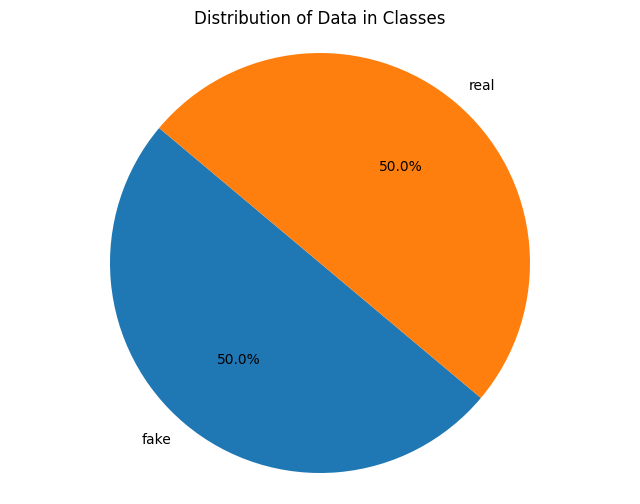

In [5]:
# Get class indices
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)

# Inverse mapping
inverse_class_indices = {v: k for k, v in class_indices.items()}
print("Class 0:", inverse_class_indices[0])
print("Class 1:", inverse_class_indices[1])

# Class counts (combine train and valid for pie chart)
class_counts = np.bincount(train_generator.classes) + np.bincount(valid_generator.classes)
class_names = ['fake', 'real']

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Data in Classes')
plt.axis('equal')
plt.show()


In [6]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.0, 1: 1.0}


In [7]:
# Load VGG16 base model (pre-trained on ImageNet, exclude top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Optional: Add more layers if needed
predictions = Dense(1, activation='sigmoid')(x)  # Binary output

# Create full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers (for transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


I0000 00:00:1753771875.909893      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,025 (58.14 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# ModelCheckpoint
tl_checkpoint_1 = ModelCheckpoint(
    filepath=f'{SAVE_NAME}.weights.best.keras',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Adjust as needed (original was 20)
    restore_best_weights=True,
    mode='min'
)


In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[tl_checkpoint_1, early_stop],
    verbose=1
)


Epoch 1/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5763 - loss: 0.6717
Epoch 1: val_loss improved from inf to 0.62406, saving model to vgg16_real_fake_model.weights.best.keras
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2364s 378ms/step - accuracy: 0.5763 - loss: 0.6717 - val_accuracy: 0.6507 - val_loss: 0.6241
Epoch 2/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6197 - loss: 0.6485
Epoch 2: val_loss improved from 0.62406 to 0.61337, saving model to vgg16_real_fake_model.weights.best.keras
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1491s 238ms/step - accuracy: 0.6197 - loss: 0.6485 - val_accuracy: 0.6622 - val_loss: 0.6134
Epoch 3/20
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6316 - loss: 0.6395
Epoch 3: val_loss improved from 0.61337 to 0.60174, saving model to vgg16_real_fake_model.weights.best.keras
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 1475s 236ms/step - accuracy: 0.6316 - loss: 0.6395 - val_accuracy: 0.6724 - val_loss: 0.6017
Epoch 4/20
6250/6250 ━━━━━━━━━━━━━━

In [16]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model

# Load VGG-16, excluding the “top” classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract embeddings (could be Flatten or GlobalAveragePooling2D)
x = base_model.output
x = Flatten()(x)  # or GlobalAveragePooling2D()(x)

# Add two dense layers with 2048 units each, ReLU activation
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)

# Output layer (change units depending on binary or multi-class)
output = Dense(1, activation='sigmoid')(x)  # For binary; use 'softmax' and more units for multiclass

# Define the model
model = Model(inputs=base_model.input, outputs=output)


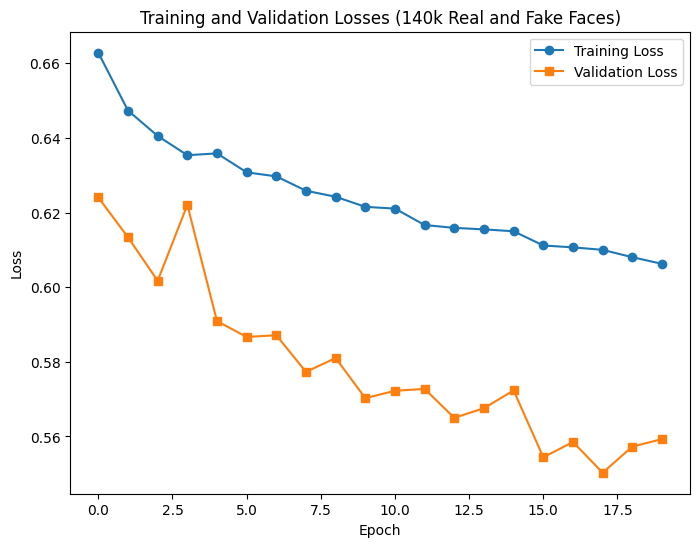

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses (140k Real and Fake Faces)')
plt.legend()
plt.show()


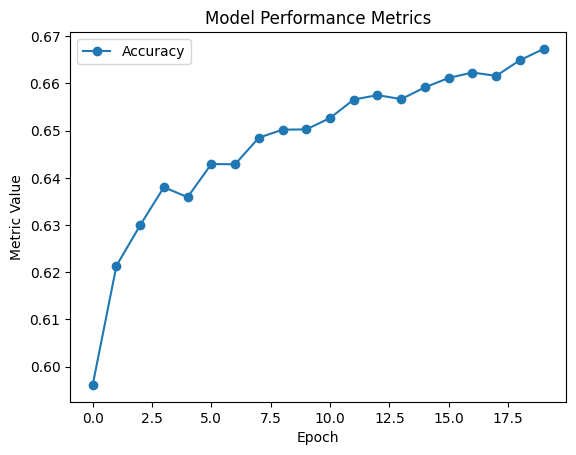

In [26]:
plt.plot(history.history['accuracy'], label='Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Model Performance Metrics')
plt.legend()
plt.show()


In [13]:
# Calculate class weights based on class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',  # Use balanced class weights that handles class imbalances
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert class weights to dictionary format
class_weights_dict = dict(enumerate(class_weights))


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 195s 10ms/step
              precision    recall  f1-score   support

        fake       0.71      0.71      0.71     10000
        real       0.71      0.71      0.71     10000

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Accuracy: 0.71225


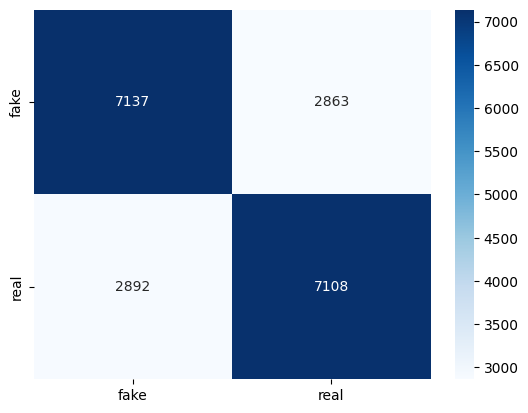

In [14]:
# Load best model
model = load_model(f'{SAVE_NAME}.weights.best.keras')

# Predict on test set
test_generator.reset()  # Reset for clean predictions
predictions = model.predict(test_generator, steps=test_generator.samples)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()  # Threshold for binary

# True labels
true_classes = test_generator.classes

# Metrics
print(classification_report(true_classes, predicted_classes, target_names=class_subset))
print("Accuracy:", accuracy_score(true_classes, predicted_classes))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_subset, yticklabels=class_subset)
plt.show()


In [ ]:
# Example: Predict on one image
img_path = os.path.join(TEST_DIR, 'real', os.listdir(os.path.join(TEST_DIR, 'real'))[0])  # Adjust path
img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
img_array = tf.keras.utils.img_to_array(img) / 255.
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0][0]
label = 'real' if pred > 0.5 else 'fake'  # Adjust based on your class_indices
print(f"Predicted: {label} (confidence: {pred:.2f})")
plt.imshow(img)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
Predicted: fake (confidence: 0.39)
